In [16]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import math

# ------------------- CONFIG -------------------
# SUBFOLDERS = {"defected": 0, "non_defected": 1}
ANGLE_STEP = 10
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
USE_HOUGH = False
OUTPUT_BASE_DIR = Path(r"D:\manu project\new")  # Output folder for CSV and annotated images
ANNOTATED_DIR = OUTPUT_BASE_DIR / "annotated"

# ------------------- STEP 1: BACKGROUND REMOVAL -------------------
def remove_background(img_path):
    img = cv2.imread(img_path)
    output = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    result = cv2.bitwise_and(output, output, mask=mask)
    return img, mask, result

def save_background_removed_dataset(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for label_dir in SUBFOLDERS.keys():
        in_path = os.path.join(input_dir, label_dir)
        out_path = os.path.join(output_dir, label_dir)
        os.makedirs(out_path, exist_ok=True)
        for img_name in os.listdir(in_path):
            img_path = os.path.join(in_path, img_name)
            _, _, result = remove_background(img_path)
            cv2.imwrite(os.path.join(out_path, img_name), result)
    print(f"[STEP 1] Background-removed dataset saved at: {output_dir}")

# ------------------- STEP 2: OUTER CONTOUR -------------------
def largest_external_contour(bin_img):
    cnts, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        raise ValueError("No contour found.")
    return max(cnts, key=cv2.contourArea)

def save_outer_contour_dataset(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for label_dir in SUBFOLDERS.keys():
        in_path = os.path.join(input_dir, label_dir)
        out_path = os.path.join(output_dir, label_dir)
        os.makedirs(out_path, exist_ok=True)
        for fname in os.listdir(in_path):
            img_path = os.path.join(in_path, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                outer_contour = max(contours, key=cv2.contourArea)
                contour_img = np.zeros_like(img)
                cv2.drawContours(contour_img, [outer_contour], -1, (255,255,255), 2)
                cv2.imwrite(os.path.join(out_path, fname), contour_img)
    print(f"[STEP 2] Outer contour dataset saved at: {output_dir}")

# ------------------- STEP 3 & 4: RADIUS MEASUREMENT -------------------
def estimate_center_and_radius(cnt):
    (cx, cy), r = cv2.minEnclosingCircle(cnt)
    return (float(cx), float(cy)), float(r)

def ray_hit_point(edge_img, center, theta_deg, max_step=None):
    h, w = edge_img.shape[:2]
    cx, cy = center
    theta = math.radians(theta_deg)
    cos_t, sin_t = math.cos(theta), math.sin(theta)
    if max_step is None:
        max_step = int(2 * math.hypot(w, h))
    for r in range(1, max_step):
        x = int(round(cx + r * cos_t))
        y = int(round(cy + r * sin_t))
        if x < 0 or y < 0 or x >= w or y >= h:
            return None, float("nan")
        if edge_img[y, x] > 0:
            return (x, y), float(r)
    return None, float("nan")

def process_image(img_path, angle_step=ANGLE_STEP, use_hough=USE_HOUGH):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    bin_thick = cv2.dilate(bin_img, np.ones((3,3), np.uint8), iterations=1)
    cnt = largest_external_contour(bin_thick)
    (cx, cy), _ = estimate_center_and_radius(cnt)
    center = (cx, cy)
    angles = list(range(0, 360, angle_step))
    radii = []
    overlay = img.copy()
    for ang in angles:
        hit, r = ray_hit_point(bin_thick, center, ang)
        radii.append(r)
        if hit is not None:
            cv2.line(overlay, (int(round(cx)), int(round(cy))), hit, (0,255,0), 1)
    cv2.circle(overlay, (int(round(cx)), int(round(cy))), 3, (0,0,255), -1)
    out_img = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)
    return out_img, (cx, cy), angles, radii

# ------------------- STEP 5: PROCESS DATASET & SAVE CSV -------------------
def generate_final_csv(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    OUT_IMG_DIR = output_dir / "annotated"
    os.makedirs(OUT_IMG_DIR, exist_ok=True)
    rows = []
    angle_cols = [f"r_{a:03d}" for a in range(0, 360, ANGLE_STEP)]
    for label, label_val in SUBFOLDERS.items():
        folder = input_dir / label
        if not folder.exists():
            continue
        for p in sorted(folder.rglob("*")):
            if p.suffix.lower() not in IMG_EXTS:
                continue
            try:
                annotated, (cx, cy), angles, radii = process_image(str(p))
            except Exception as e:
                print(f"[ERROR] {p}: {e}")
                continue
            rel = p.relative_to(input_dir)
            out_img_path = OUT_IMG_DIR / rel.with_suffix(".png")
            out_img_path.parent.mkdir(parents=True, exist_ok=True)
            cv2.imwrite(str(out_img_path), annotated)
            row = {
                "file": str(rel).replace("\\","/"),
                "defect_status": label_val,
                "center_x": cx,
                "center_y": cy,
            }
            row.update({col:r for col,r in zip(angle_cols,radii)})
            rows.append(row)
    df = pd.DataFrame(rows, columns=["file","defect_status","center_x","center_y"]+angle_cols)
    # compute min, max, ratio
    df["r_min"] = df[angle_cols].min(axis=1)
    df["r_max"] = df[angle_cols].max(axis=1)
    df["r_ratio"] = df["r_max"] / df["r_min"]
    
   # Only keep image filename and r_ratio
    # df_final = df[["file", "r_ratio", "center_x", "center_y"]].copy() # for testing
    df_final = df[["file", "r_ratio", "defect_status"]].copy() # for training
    final_csv = output_dir / "final_data_filewith_ratios.csv"
    df_final.to_csv(final_csv, index=False)
    print(f"[STEP 5] Final CSV saved at: {output_dir / 'final_data_filewith_ratios.csv'}")

# ------------------- MAIN PIPELINE -------------------
def run_pipeline(raw_dataset_dir):
    raw_dataset_dir = Path(raw_dataset_dir)
    cleaned_dir = Path(OUTPUT_BASE_DIR / "dataset_cleaned")
    outer_dir = Path(OUTPUT_BASE_DIR / "dataset_outer_contour")
    save_background_removed_dataset(raw_dataset_dir, cleaned_dir)
    save_outer_contour_dataset(cleaned_dir, outer_dir)
    generate_final_csv(outer_dir, OUTPUT_BASE_DIR)

if __name__ == "__main__":
    dataset_path = r"D:\manu project\new\dataset\defected\IMG_9588 Top Cup 134 (2).JPG"  # <- Raw dataset folder
    run_pipeline(dataset_path)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\manu project\\new\\dataset\\defected\\IMG_9588 Top Cup 134 (2).JPG\\defected'

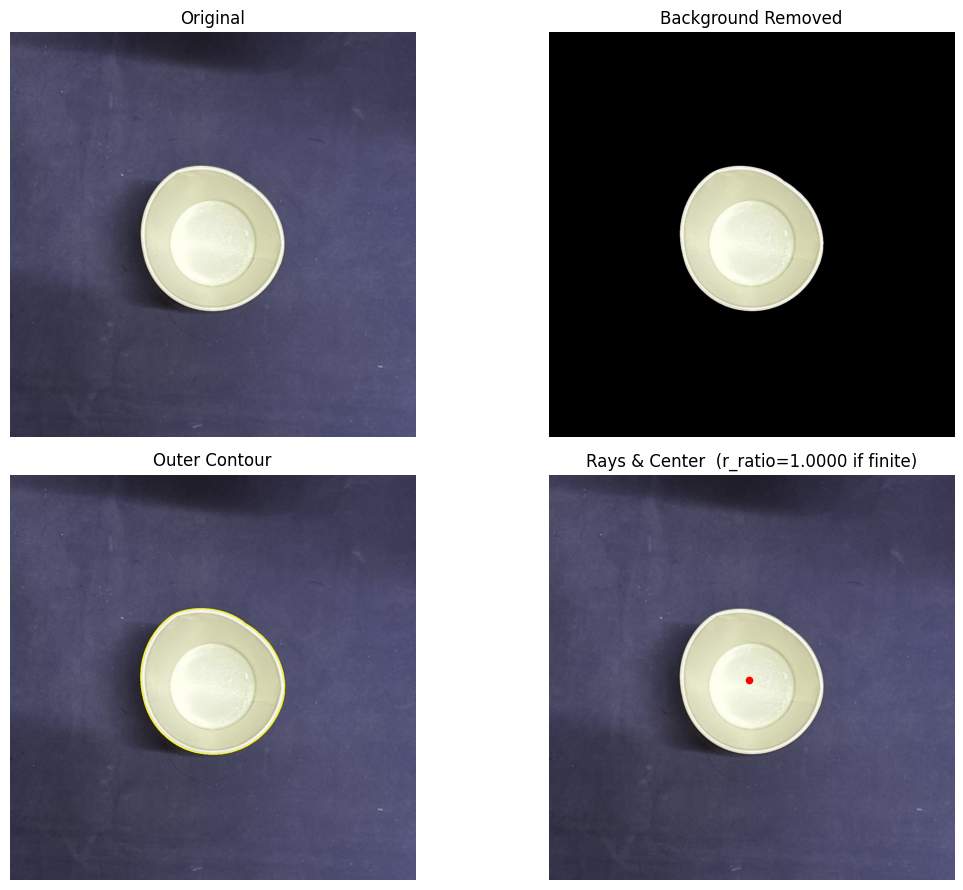

Center = (646.37, 662.38)
r_min = 1.0000, r_max = 1.0000, r_ratio = 1.000000
Radii along each angle:
Angle 000°: 1.0000
Angle 010°: 1.0000
Angle 020°: 1.0000
Angle 030°: 1.0000
Angle 040°: 1.0000
Angle 050°: 1.0000
Angle 060°: 1.0000
Angle 070°: 1.0000
Angle 080°: 1.0000
Angle 090°: 1.0000
Angle 100°: 1.0000
Angle 110°: 1.0000
Angle 120°: 1.0000
Angle 130°: 1.0000
Angle 140°: 1.0000
Angle 150°: 1.0000
Angle 160°: 1.0000
Angle 170°: 1.0000
Angle 180°: 1.0000
Angle 190°: 1.0000
Angle 200°: 1.0000
Angle 210°: 1.0000
Angle 220°: 1.0000
Angle 230°: 1.0000
Angle 240°: 1.0000
Angle 250°: 1.0000
Angle 260°: 1.0000
Angle 270°: 1.0000
Angle 280°: 1.0000
Angle 290°: 1.0000
Angle 300°: 1.0000
Angle 310°: 1.0000
Angle 320°: 1.0000
Angle 330°: 1.0000
Angle 340°: 1.0000
Angle 350°: 1.0000


In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

ANGLE_STEP = 10  # change if you want denser sampling

# ---------- helpers ----------
def _bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def remove_background_from_image(img):
    """Return (mask, bg_removed)."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    result = cv2.bitwise_and(img, img, mask=mask)
    return mask, result

def largest_external_contour(bin_img):
    cnts, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        raise ValueError("No contour found.")
    return max(cnts, key=cv2.contourArea)

def estimate_center_from_contour(cnt):
    (cx, cy), r = cv2.minEnclosingCircle(cnt)
    return (float(cx), float(cy)), float(r)

def ray_hit_point(edge_img, center, theta_deg, max_step=None):
    h, w = edge_img.shape[:2]
    cx, cy = center
    theta = math.radians(theta_deg)
    cos_t, sin_t = math.cos(theta), math.sin(theta)
    if max_step is None:
        max_step = int(2 * math.hypot(w, h))
    for r in range(1, max_step):
        x = int(round(cx + r * cos_t))
        y = int(round(cy + r * sin_t))
        if x < 0 or y < 0 or x >= w or y >= h:
            return None, float("nan")
        if edge_img[y, x] > 0:
            return (x, y), float(r)
    return None, float("nan")

def measure_radii(bin_img, center, angle_step=10):
    angles = list(range(0, 360, angle_step))
    radii = []
    for ang in angles:
        _, r = ray_hit_point(bin_img, center, ang)
        radii.append(r)
    return angles, radii

def compute_r_ratio(radii):
    valid = [r for r in radii if np.isfinite(r) and r > 0]
    if len(valid) == 0:
        return float("nan"), float("nan"), float("nan")
    r_min = float(np.min(valid))
    r_max = float(np.max(valid))
    return r_min, r_max, (r_max / r_min if r_min > 0 else float("nan"))

# ---------- visualization ----------
def show_intermediate(original, bg_removed, contour_overlay, rays_overlay, center, r_ratio):
    cx, cy = center
    plt.figure(figsize=(12, 9))

    plt.subplot(2,2,1)
    plt.title("Original")
    plt.imshow(_bgr2rgb(original))
    plt.axis("off")

    plt.subplot(2,2,2)
    plt.title("Background Removed")
    plt.imshow(_bgr2rgb(bg_removed))
    plt.axis("off")

    plt.subplot(2,2,3)
    plt.title("Outer Contour")
    plt.imshow(_bgr2rgb(contour_overlay))
    plt.axis("off")

    plt.subplot(2,2,4)
    plt.title(f"Rays & Center  (r_ratio={r_ratio:.4f} if finite)")
    plt.imshow(_bgr2rgb(rays_overlay))
    plt.scatter([cx], [cy], s=20, c='red')  # center dot (matplotlib draws in RGB)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---------- main single-image pipeline ----------
def run_single_image(img_path, angle_step=ANGLE_STEP, show=True):
    # read
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")

    # step 1: background removal
    mask, bg_removed = remove_background_from_image(img)

    # step 2: outer contour (on bg-removed)
    gray_rm = cv2.cvtColor(bg_removed, cv2.COLOR_BGR2GRAY)
    _, bin_img = cv2.threshold(gray_rm, 1, 255, cv2.THRESH_BINARY)
    bin_thick = cv2.dilate(bin_img, np.ones((3,3), np.uint8), iterations=1)

    cnt = largest_external_contour(bin_thick)
    (cx, cy), _ = estimate_center_from_contour(cnt)
    center = (cx, cy)

    contour_overlay = img.copy()
    cv2.drawContours(contour_overlay, [cnt], -1, (0, 255, 255), 2)

def process_image(img_path, angle_step=ANGLE_STEP, use_hough=USE_HOUGH):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    bin_thick = cv2.dilate(bin_img, np.ones((3,3), np.uint8), iterations=1)
    cnt = largest_external_contour(bin_thick)
    (cx, cy), _ = estimate_center_and_radius(cnt)
    center = (cx, cy)
    angles = list(range(0, 360, angle_step))
    radii = []
    overlay = img.copy()
    for ang in angles:
        hit, r = ray_hit_point(bin_thick, center, ang)
        radii.append(r)
        if hit is not None:
            cv2.line(overlay, (int(round(cx)), int(round(cy))), hit, (0,255,0), 1)
    cv2.circle(overlay, (int(round(cx)), int(round(cy))), 3, (0,0,255), -1)
    out_img = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)
    return out_img, (cx, cy), angles, radii

    # step 5: r_ratio
    r_min, r_max, r_ratio = compute_r_ratio(radii)

    if show:
        show_intermediate(img, bg_removed, contour_overlay, rays_overlay, center, r_ratio)

    # Print results
    print(f"Center = ({cx:.2f}, {cy:.2f})")
    print(f"r_min = {r_min:.4f}, r_max = {r_max:.4f}, r_ratio = {r_ratio:.6f}")
    print("Radii along each angle:")
    for ang, r in zip(angles, radii):
        print(f"Angle {ang:03d}°: {r:.4f}")

    return {
        "center": center,
        "angles": angles,
        "radii": radii,
        "r_min": r_min,
        "r_max": r_max,
        "r_ratio": r_ratio,
        "rays_overlay": rays_overlay,
        "contour_overlay": contour_overlay,
        "bg_removed": bg_removed,
    }

# ---------- example usage ----------
if __name__ == "__main__":
    IMG_PATH = r"D:\manu project\new\dataset\defected\IMG_9588 Top Cup 134 (2).JPG"
    run_single_image(IMG_PATH, angle_step=10, show=True)